# Introduction

In this study, we are interested in the some types of regression problems, whose errors should be evaluated asymetrically.
As an example, imagin you sell newspappers and that the cost of production of a newspapper is 0.5€, but you can sell it 2€.
It implies that:
- for every newspapper you do not sell, you loose 0.5€
- for every newspapper that you miss selling, you loose 2€ - 0.5€ (of printing) = 1.5€

In this study, we will present and evaluate 3 different techniques to tackle this problem.



In [1]:
import math
import pandas as pd

from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import six
import sys
sys.modules['sklearn.externals.six'] = six
from skgarden import RandomForestQuantileRegressor

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 5)

RANDOM_STATE = 42

/Users/nabil.belaid/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/nabil.belaid/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Define the different metrics that we will use
def rmse(y_test, y_pred):
    """
    Compte the Root Mean Square Error
    """
    return math.sqrt(mean_squared_error(y_test, y_pred))

def mae(y_test, y_pred):
    """
    Compte the Mean Absolute Error
    """
    return mean_absolute_error(y_test, y_pred)

def asym_loss(y_test, y_pred, over_loss, under_loss):
    """
    Compte the Mean Asymetric Error
    """
    y_diff = y_pred - y_test
    over_pred_loss = (y_diff[y_diff > 0]).sum() * over_loss
    under_pred_loss = (y_diff[y_diff < 0]).sum() * under_loss
    return over_pred_loss - under_pred_loss


In [3]:
df = pd.read_csv("data/weekly_newspaper.csv")
print(df.shape)
df.head()

(64177, 10)


,id,selling_date,selling_week,selling_month,selling_year,location,is_temporary,is_holiday,selling_store,sold_number
0,8559776,20041130,48,11,2004,44,0,0,452,7
1,8559767,20041130,48,11,2004,44,0,0,451,4
2,8559681,20041130,48,11,2004,44,0,0,1617,12
3,8559671,20041130,48,11,2004,44,0,0,1616,2
4,8559662,20041130,48,11,2004,44,0,0,1615,3


In [4]:
predictor_cols = [
    "selling_week",
    "selling_month",
    "selling_year",
    "location",
    "is_temporary",
    "is_holiday",
    "selling_store",
]
    
date_column = "selling_date"
target_column = "sold_number"

In [5]:
# Load the X dataset and y target train validation test
def split_X_y_train_test(
        df: pd.DataFrame(),
        predictor_cols: list,
        target_col: str,
        col_to_split_on : str,
        value_to_split_on: int):
    """
    Split X features and y target for train and test
    """
    df_train = df[df[col_to_split_on] < value_to_split_on]
    df_test = df[df[col_to_split_on] >= value_to_split_on]
    X_train = df_train[predictor_cols]
    y_train = df_train[target_col]
    X_test = df_test[predictor_cols]
    y_test = df_test[target_col]

    return X_train, y_train, X_test, y_test

# Do the split
X_train, y_train, X_test, y_test = split_X_y_train_test(
    df, predictor_cols, target_column,
    date_column, 20040101)

# Split again to get the validation and test
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=0.2, random_state=RANDOM_STATE)

In [6]:
OVER_LOSS = 0.5
UNDER_LOSS = 1.5

# Straitforward model
Here, we present the results of the training of a model without taking into account the specificity of the asymetric error evaluation.
Note that we will use a Random Forest Regressor model and which will be our "control" model.


In [7]:
# Train a RandomForestRegressor
model = RandomForestRegressor(n_estimators=10, criterion="mse", random_state=RANDOM_STATE)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)


In [8]:
# Evaluation of the test dataset
y_valid_pred = model.predict(X_valid)

print("RMSE: ", rmse(y_valid, y_valid_pred))
print("MAE: ", mae(y_valid, y_valid_pred))
total_amount = asym_loss(y_valid, y_valid_pred, OVER_LOSS, UNDER_LOSS)
mean_amount = total_amount / len(y_valid)
print("Mean asymmetric money loss (compared to optimum): ", mean_amount)


RMSE:  2.5710727304516565
MAE:  1.6628447574934075
Mean asymmetric money loss (compared to optimum):  1.3819756144402426


In [9]:
# Evaluation of the validation dataset
y_test_pred = model.predict(X_test)

print("RMSE: ", rmse(y_test, y_test_pred))
print("MAE: ", mae(y_test, y_test_pred))
total_amount = asym_loss(y_test, y_test_pred, OVER_LOSS, UNDER_LOSS)
mean_amount = total_amount / len(y_test)
print("Mean asymmetric money loss (compared to optimum): ", mean_amount)


RMSE:  2.5204673713528654
MAE:  1.6410079780782227
Mean asymmetric money loss (compared to optimum):  1.3924949688564525


In what follows, we will see 3 different techniques to tackle the asymetric evaluation of the error:
- Generalized increase of all predictions
- Selection by higher quantile in regression trees
- Asymmetric falsification of training data

We will explain each technique in what follows.

# Technique 1: Generalized increase of all predictions
This technique is the easiest to understand and to implement.
Its principle is straightforward: you systematically multiply the predicted value by a factor.
And then you evaluate for each factor multiplication, the gain in the performances.


In [10]:
# First, train a model
model = RandomForestRegressor(n_estimators=10, criterion="mse", random_state=RANDOM_STATE)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=42)

In [11]:
# Compute the asymetric loss (on the validation set) by varying the factor of multiplication
percentage_list = []
mean_asym_loss_list = []

for per_to_aug in range(1, 100):
    percentage_list.append(per_to_aug)
    
    rate_to_aug = 1 + (per_to_aug / 100)
    print("rate: ", rate_to_aug)
    
    y_valid_pred = model.predict(X_valid)
    y_valid_pred = y_valid_pred * rate_to_aug
    
    print("RMSE: ", rmse(y_valid, y_valid_pred))
    print("MAE: ", mae(y_valid, y_valid_pred))
    total_amount = asym_loss(y_valid, y_valid_pred, OVER_LOSS, UNDER_LOSS)
    mean_amount = total_amount / len(y_valid)
    print("Mean asymmetric money loss: ", mean_amount)
    mean_asym_loss_list.append(mean_amount)
    print()

evol_loss_df = pd.DataFrame({
        "percentage": percentage_list,
        "mean_asym_loss": mean_asym_loss_list,
    })

rate:  1.01
RMSE:  2.5991208535396724
MAE:  1.679915714342949
Mean asymmetric money loss:  1.3755414949827822

rate:  1.02
RMSE:  2.6286678521975726
MAE:  1.6976866475126422
Mean asymmetric money loss:  1.3698073518454734

rate:  1.03
RMSE:  2.659663772526285
MAE:  1.7162380513851005
Mean asymmetric money loss:  1.3648536794109298

rate:  1.04
RMSE:  2.692058567052367
MAE:  1.7356437268391094
Mean asymmetric money loss:  1.360754278557937

rate:  1.05
RMSE:  2.7258023614765037
MAE:  1.7558421338951915
Mean asymmetric money loss:  1.3574476093070178

rate:  1.06
RMSE:  2.760845692729181
MAE:  1.7768554092650057
Mean asymmetric money loss:  1.3549558083698297

rate:  1.07
RMSE:  2.797139718378616
MAE:  1.7985265700243531
Mean asymmetric money loss:  1.3531218928221753

rate:  1.08
RMSE:  2.8346363980307387
MAE:  1.8209158030185144
Mean asymmetric money loss:  1.3520060495093351

rate:  1.09
RMSE:  2.8732886478371262
MAE:  1.844016916342991
Mean asymmetric money loss:  1.3516020865268097


RMSE:  6.547462601519844
MAE:  4.255967738077299
Mean asymmetric money loss:  2.2357229483060026

rate:  1.75
RMSE:  6.611631605924519
MAE:  4.299798223224032
Mean asymmetric money loss:  2.256048357145733

rate:  1.76
RMSE:  6.675891678754127
MAE:  4.34368260107474
Mean asymmetric money loss:  2.27642765868944

rate:  1.77
RMSE:  6.740240215325912
MAE:  4.387655192938655
Mean asymmetric money loss:  2.296895174246354

rate:  1.78
RMSE:  6.804674705963126
MAE:  4.431695600505694
Mean asymmetric money loss:  2.3174305055063904

rate:  1.79
RMSE:  6.86919273186388
MAE:  4.475772670679997
Mean asymmetric money loss:  2.338002499373691

rate:  1.8
RMSE:  6.933791961174514
MAE:  4.519887312880505
Mean asymmetric money loss:  2.358612065267198

rate:  1.81
RMSE:  6.998470145256361
MAE:  4.564028529133162
Mean asymmetric money loss:  2.3792482052128525

rate:  1.8199999999999998
RMSE:  7.063225115135465
MAE:  4.608228787141283
Mean asymmetric money loss:  2.3999433869139732

rate:  1.83
RMSE:

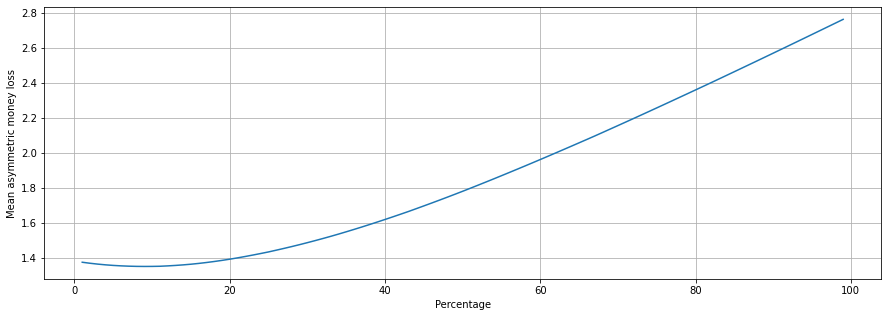

In [12]:
# Plot the mean asymetric loss according the factor
plt.plot(evol_loss_df['percentage'], evol_loss_df['mean_asym_loss'])
plt.grid(True)
plt.xlabel('Percentage')
plt.ylabel('Mean asymmetric money loss')
plt.show()

In [13]:
# Determine the best multiplication factor
index_min = evol_loss_df.idxmin(axis = 0)["mean_asym_loss"]
best_percentage = evol_loss_df.iloc[index_min]['percentage']
best_percentage

9.0

In [14]:
# Compute the mean asymetric loss on the test dataset according the the best multiplication factor
rate_to_aug = 1 + (best_percentage / 100)

y_valid_pred = model.predict(X_valid)
y_valid_pred = y_valid_pred * rate_to_aug

print("RMSE: ", rmse(y_valid, y_valid_pred))
print("MAE: ", mae(y_valid, y_valid_pred))
total_amount = asym_loss(y_valid, y_valid_pred, OVER_LOSS, UNDER_LOSS)
mean_amount = total_amount / len(y_valid)
print("Mean asymmetric money loss (compared to optimum): ", mean_amount)


RMSE:  2.8732886478371262
MAE:  1.844016916342991
Mean asymmetric money loss (compared to optimum):  1.3516020865268097


We notice a reducing of the loss from 1.392€ to 1.351€.

# Technique 2: Selection by higher quantile in regression trees
This technique is based on the the selection of a specific quantile instead of the median or average in the classical decision trees approach.
We base on a library which implements this approach.

In [15]:
# Train a the Random Forest "Quantile" Regressor that extends the standart scikit implementation
model = RandomForestQuantileRegressor(n_estimators=10, criterion="mse", random_state=RANDOM_STATE)
model.fit(X_train, y_train)

/Users/nabil.belaid/anaconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py:327: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)
/Users/nabil.belaid/anaconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py:327: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)
/Users/nabil.belaid/anaconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py:327: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)
/Users/nabil.belaid/anaconda3/lib/python3.6/site-packages/sklearn/tree/_classes.py:327: FutureWarning: The parameter 'presort' is dep

RandomForestQuantileRegressor(random_state=42)

In [16]:
# Compute the mean asymetric loss (on the validation set) by varying the quantile
# Note that this specific implementation (at this current version) is slow
percentage_list = []
mean_asym_loss_list = []

#for i in range(1, 100):
for i in [10,20,30,40,50,60,70,80,90]:
    percentage_list.append(i)
    print("Quantile:", i)
    y_valid_pred = model.predict(X_valid, quantile=i)

    print("RMSE:", rmse(y_valid, y_valid_pred))
    print("MAE:", mae(y_valid, y_valid_pred))
    total_amount = asym_loss(y_valid, y_valid_pred, OVER_LOSS, UNDER_LOSS)
    mean_amount = total_amount / len(y_valid)
    print("Mean asymmetric money loss (compared to optimum):", mean_amount)
    mean_asym_loss_list.append(mean_amount)
    print()
    

evol_loss_df = pd.DataFrame({
        "percentage": percentage_list,
        "mean_asym_loss": mean_asym_loss_list,
    })

Quantile: 10
RMSE: 2.648219751032231
MAE: 1.6774242579125813
Mean asymmetric money loss (compared to optimum): 2.029805467573433

Quantile: 20
RMSE: 2.54581791239489
MAE: 1.6207645853694155
Mean asymmetric money loss (compared to optimum): 1.8018224421383269

Quantile: 30
RMSE: 2.524632615895418
MAE: 1.6132646293573543
Mean asymmetric money loss (compared to optimum): 1.6398686586166447

Quantile: 40
RMSE: 2.5534726472838116
MAE: 1.638215909075281
Mean asymmetric money loss (compared to optimum): 1.516808071631148

Quantile: 50
RMSE: 2.639319434449881
MAE: 1.6962092990971038
Mean asymmetric money loss (compared to optimum): 1.427544909612238

Quantile: 60
RMSE: 2.7885374066281847
MAE: 1.7834933756640887
Mean asymmetric money loss (compared to optimum): 1.3647182932708428

Quantile: 70
RMSE: 2.995019384446774
MAE: 1.9062070757178657
Mean asymmetric money loss (compared to optimum): 1.3302375629426126

Quantile: 80
RMSE: 3.2451853046602555
MAE: 2.0673566385995157
Mean asymmetric money lo

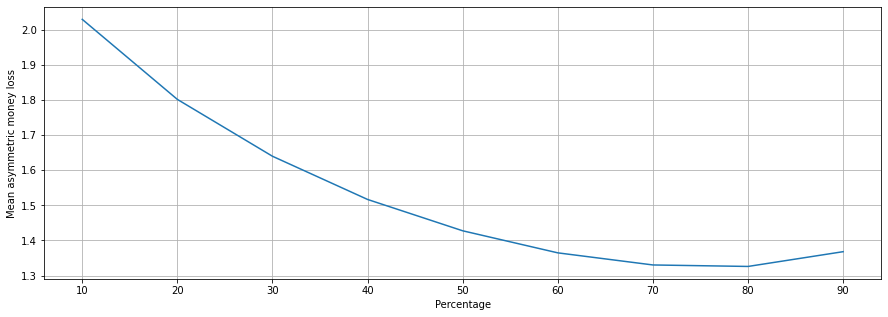

In [17]:
# Plot the mean asymetric loss according the factor
plt.plot(evol_loss_df['percentage'], evol_loss_df['mean_asym_loss'])
plt.grid(True)
plt.xlabel('Percentage')
plt.ylabel('Mean asymmetric money loss')
plt.show()

In [18]:
# Determine the quantile that gives the best outcome on the validation dataset
index_min = evol_loss_df.idxmin(axis = 0)["mean_asym_loss"]
best_percentage = evol_loss_df.iloc[index_min]['percentage']
best_percentage

80.0

In [19]:
# Compute the mean asymetric loss on the test dataset on the best retained quantile
y_test_pred = model.predict(X_test, quantile=best_percentage)

print("RMSE: ", rmse(y_test, y_test_pred))
print("MAE: ", mae(y_test, y_test_pred))
total_amount = asym_loss(y_test, y_test_pred, OVER_LOSS, UNDER_LOSS)
mean_amount = total_amount / len(y_test)
print("Mean asymmetric money loss (compared to optimum): ", mean_amount)


RMSE:  3.1940852239410877
MAE:  2.032219712850274
Mean asymmetric money loss (compared to optimum):  1.327702358861495


We notice a reducing of the loss from 1.392€ to 1.327€.

# Technique 3: Asymmetric falsification of training data
This approach is original.
It consists in training a first model.
Then, we "falsify" the training data by majorating the instances that the model under-estimated.
We then evaluate the new performance on new data.

In [20]:
# First, train a model once
model = RandomForestRegressor(n_estimators=10, criterion="mse", random_state=RANDOM_STATE)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)

In [21]:
# Evaluate the model after the first iteration of training
y_valid_pred = model.predict(X_valid)

print("RMSE: ", rmse(y_valid, y_valid_pred))
print("MAE: ", mae(y_valid, y_valid_pred))
total_amount = asym_loss(y_valid, y_valid_pred, OVER_LOSS, UNDER_LOSS)
mean_amount = total_amount / len(y_valid)
print("Mean asymmetric money loss (compared to optimum): ", mean_amount)


RMSE:  2.5710727304516565
MAE:  1.6628447574934075
Mean asymmetric money loss (compared to optimum):  1.3819756144402426


In [22]:
# Save the original train target
y_train_it_0 = y_train

In [23]:
# Apply different majorations to the underestimated instances and compute the mean asymetric loss (on the validation set)
percentage_list = []
mean_asym_loss_list = []

for per_to_aug in range(1, 100):
    percentage_list.append(per_to_aug)
    
    rate_to_aug = per_to_aug / 100
    print("rate: ", rate_to_aug)
    
    y_train = y_train_it_0
    to_be_aug = (y_train_pred - y_train)<0
    y_train = y_train * (1 + (rate_to_aug * to_be_aug))
    
    model = RandomForestRegressor(n_estimators=10, criterion="mse", random_state=RANDOM_STATE)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    
    y_valid_pred = model.predict(X_valid)
    print("RMSE: ", rmse(y_valid, y_valid_pred))
    print("MAE: ", mae(y_valid, y_valid_pred))
    total_amount = asym_loss(y_valid, y_valid_pred, OVER_LOSS, UNDER_LOSS)
    mean_amount = total_amount / len(y_valid)
    print("Asymmetric money loss:", mean_amount)
    mean_asym_loss_list.append(mean_amount)
    print()

evol_loss_df = pd.DataFrame({
        "percentage": percentage_list,
        "mean_asym_loss": mean_asym_loss_list,
    })

rate:  0.01
RMSE:  2.5870904720413557
MAE:  1.673015967291056
Asymmetric money loss: 1.3791226102061174

rate:  0.02
RMSE:  2.606494660382465
MAE:  1.6837453970030811
Asymmetric money loss: 1.3774102778970883

rate:  0.03
RMSE:  2.6218258881483867
MAE:  1.6932820392962473
Asymmetric money loss: 1.3742183123250136

rate:  0.04
RMSE:  2.642492131237598
MAE:  1.7035349697543753
Asymmetric money loss: 1.3716849054207036

rate:  0.05
RMSE:  2.654724827171211
MAE:  1.7112059230203323
Asymmetric money loss: 1.3721986033103721

rate:  0.06
RMSE:  2.672568458878923
MAE:  1.7229453048464416
Asymmetric money loss: 1.3715189680483784

rate:  0.07
RMSE:  2.6853591094461535
MAE:  1.728821544262694
Asymmetric money loss: 1.370322909198374

rate:  0.08
RMSE:  2.6996301589694296
MAE:  1.738837859755158
Asymmetric money loss: 1.3698161410429406

rate:  0.09
RMSE:  2.7106204318928024
MAE:  1.7446898332467125
Asymmetric money loss: 1.3695575658425647

rate:  0.1
RMSE:  2.7310915189592557
MAE:  1.756561969

RMSE:  4.083327980120479
MAE:  2.428627445311681
Asymmetric money loss: 1.5909326627445706

rate:  0.8
RMSE:  4.0634041994626475
MAE:  2.4287538970378777
Asymmetric money loss: 1.5931666500514774

rate:  0.81
RMSE:  4.139169942233679
MAE:  2.439065117165703
Asymmetric money loss: 1.5959835402942406

rate:  0.82
RMSE:  4.053772779532673
MAE:  2.4447812876689263
Asymmetric money loss: 1.6015357662982335

rate:  0.83
RMSE:  4.201314130187783
MAE:  2.4711644142278644
Asymmetric money loss: 1.609234332975459

rate:  0.84
RMSE:  4.159953499550572
MAE:  2.4766867728113877
Asymmetric money loss: 1.6141072276643729

rate:  0.85
RMSE:  4.213277013538828
MAE:  2.4924918238745497
Asymmetric money loss: 1.6203376123070061

rate:  0.86
RMSE:  4.216073650870541
MAE:  2.5013596487978917
Asymmetric money loss: 1.6232425997512192

rate:  0.87
RMSE:  4.274112915202994
MAE:  2.5218697807888435
Asymmetric money loss: 1.6317187268618893

rate:  0.88
RMSE:  4.220184176394705
MAE:  2.524881033768329
Asymmetri

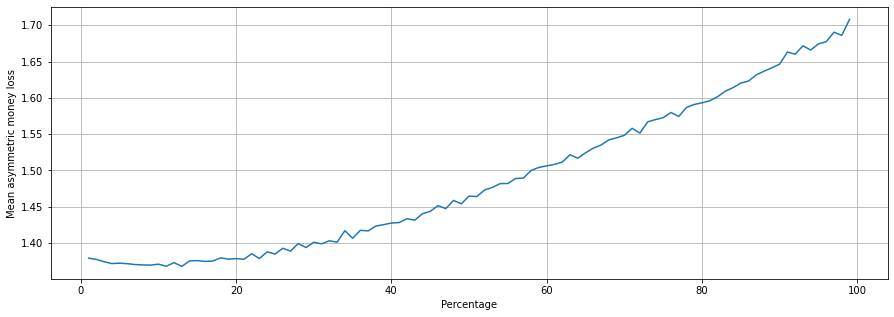

In [24]:
# Plot the mean asymetric loss according the different majorations
plt.plot(evol_loss_df['percentage'], evol_loss_df['mean_asym_loss'])
plt.grid(True)
plt.xlabel('Percentage')
plt.ylabel('Mean asymmetric money loss')
plt.show()

In [25]:
# Determine the best rate, that gives the best mean asymetric loss
index_min = evol_loss_df.idxmin(axis = 0)["mean_asym_loss"]
best_percentage = evol_loss_df.iloc[index_min]['percentage']

rate_to_aug = best_percentage / 100
print("rate: ", rate_to_aug)

y_train = y_train_it_0
to_be_aug = (y_train_pred - y_train)<0
y_train = y_train * (1 + (rate_to_aug * to_be_aug))

model = RandomForestRegressor(n_estimators=10, criterion="mse", random_state=RANDOM_STATE)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)


rate:  0.13


In [26]:
# Compute the mean asymetric loss on the test dataset on the best rate
y_test_pred = model.predict(X_test)
print("RMSE: ", rmse(y_test, y_test_pred))
print("MAE: ", mae(y_test, y_test_pred))
total_amount = asym_loss(y_test, y_test_pred, OVER_LOSS, UNDER_LOSS)
mean_amount = total_amount / len(y_test)
print("Asymmetric money loss:", mean_amount)

RMSE:  2.6556963254081474
MAE:  1.7179912834114055
Asymmetric money loss: 1.3778882222296251


We notice a reducing of the loss from 1.392€ to 1.377€.

# Summary and outlooks
As a conclusion, we can say that there are different strategies to tackle the asymetric evaluation of the error.
Note however, note that some techniques are greedy and the gain does not justify their utilization.

Here is a summary about the performances of the different techniques:

|   | Mean Asymetric Loss  | Time complexity  | Implementation complexity  |   
|---|---|---|---|
|Generalized increase of all predictions | (+) |  (++) |  (++) |   
|Selection by higher quantile in regression trees | (++)  |  (-) | (-)  |   
|Asymmetric falsification of training data |  (+) | (--)  | (+)  |   


As outlooks, we site the following:
- Implement the asymmetric cost function in scikit-learn
- Use blending of techniques
- Run a second iteration of the falsification technique
- Use a "Mirror" falsification (on the other side)